<a href="https://colab.research.google.com/github/yan-ren/comp6721-applied-ai-project/blob/main/VGG11/3DatasetVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))


Using cuda.


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import random

torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(1)
np.random.seed(1)

def load_data(path, test_split, val_split, batch_size, input_size):
    
    ######## Write your code here ########
    
    transform_dict = {
    'src': transforms.Compose(
    [transforms.Resize(input_size),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.554, 0.450, 0.343],
                          std=[0.231, 0.241, 0.241]),
     transforms.RandomErasing()
     ]
      
     )}

    data = datasets.ImageFolder(root=path, transform=transform_dict['src'])

    dataset_size = len(data)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - (test_size + val_size)

    train_dataset, test_dataset, val_dataset = td.random_split(data,
                                               [train_size, test_size, val_size])

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_test  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_val   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    
    #########################################
    
    return data_loader_train, data_loader_test, data_loader_val



path = "/content/3-Dataset"
train_loader, test_loader, val_loader = load_data(path, 0.1, 0.1, 32, (256, 256))


from torchvision import models
modelVGG3 = models.vgg11(weights=None)
modelVGG3.classifier[6] = nn.Linear(4096,3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelVGG3.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

print(modelVGG3)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
modelVGG3.to(device);   

AccuracyList=[]
AccuracyList2=[]
AccuracyListV=[]
AccuracyList2V=[]
###### Define and run your training loop here #########
num_epochs = 15
total_steps = len(train_loader)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = modelVGG3(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        AccuracyList.append((correct / total) * 100)
        if (i + 1) % 10 == 0:
            AccuracyList2.append((correct / total) * 100)
            correct_v = 0
            total_v = 0
            for dataVal in val_loader:
                images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                outputs = modelVGG3(images_v)
                _, predicted = torch.max(outputs.data, 1)
                correct_v += (predicted == labels_v).sum().item()
                total_v += labels_v.size(0)
                AccuracyListV.append((correct_v / total_v) * 100)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100, (correct_v / total_v) * 100))
            AccuracyList2V.append((correct_v / total_v) * 100)
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))   





Device: cuda
Epoch [1/15], Step [10/74], Loss: 1.0461, Accuracy: 46.88%, Validation Accuracy: 49.83%
Epoch [1/15], Step [20/74], Loss: 1.0512, Accuracy: 43.75%, Validation Accuracy: 48.81%
Epoch [1/15], Step [30/74], Loss: 0.9870, Accuracy: 53.12%, Validation Accuracy: 48.46%
Epoch [1/15], Step [40/74], Loss: 1.0539, Accuracy: 46.88%, Validation Accuracy: 48.81%
Epoch [1/15], Step [50/74], Loss: 1.1326, Accuracy: 37.50%, Validation Accuracy: 48.81%
Epoch [1/15], Step [60/74], Loss: 1.0209, Accuracy: 53.12%, Validation Accuracy: 48.81%
Epoch [1/15], Step [70/74], Loss: 0.9805, Accuracy: 46.88%, Validation Accuracy: 48.81%
Epoch [2/15], Step [10/74], Loss: 1.0113, Accuracy: 59.38%, Validation Accuracy: 48.81%
Epoch [2/15], Step [20/74], Loss: 1.0010, Accuracy: 62.50%, Validation Accuracy: 48.81%
Epoch [2/15], Step [30/74], Loss: 0.9533, Accuracy: 53.12%, Validation Accuracy: 48.81%
Epoch [2/15], Step [40/74], Loss: 0.9825, Accuracy: 46.88%, Validation Accuracy: 50.51%
Epoch [2/15], Step 

Test Accuracy of the model on the 293 test images: 66.21160409556313 %
Confusion matrix:
[[ 38  10  48]
 [ 14  16  16]
 [  9   2 140]]
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.40      0.48        96
           1       0.57      0.35      0.43        46
           2       0.69      0.93      0.79       151

    accuracy                           0.66       293
   macro avg       0.63      0.56      0.57       293
weighted avg       0.65      0.66      0.63       293



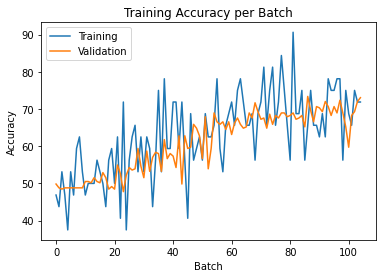

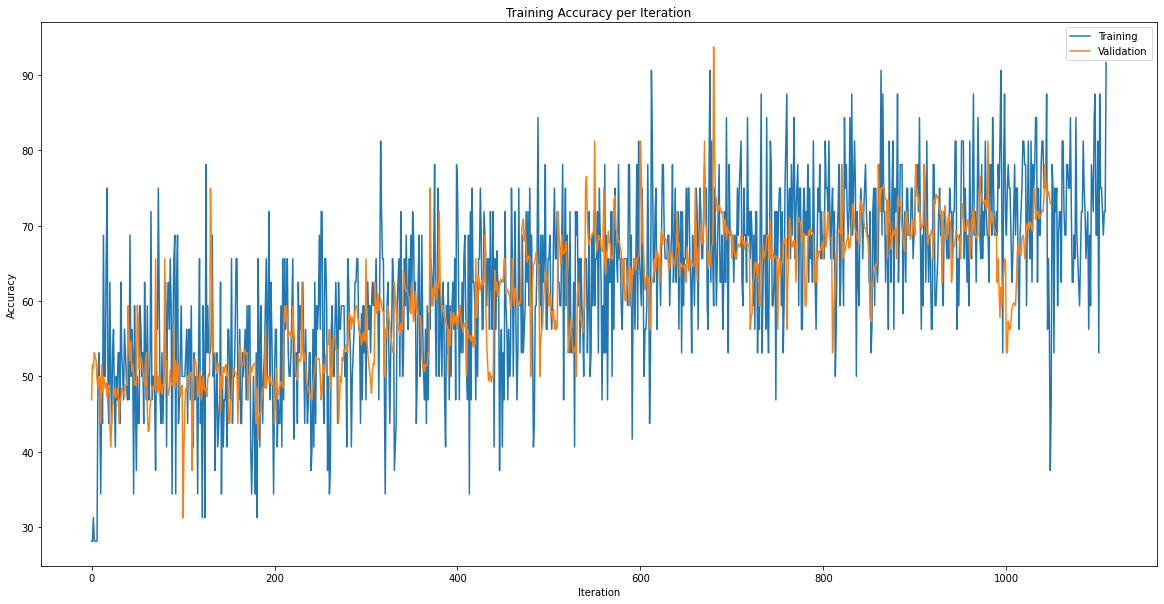

In [ ]:

modelVGG3.eval() 
predicted_labels = []
true_labels = []

y_scores = []
y_true = []

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = modelVGG3(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels += predicted.cpu().numpy().tolist()
        true_labels += labels.cpu().numpy().tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        probs = F.softmax(outputs, dim=1)
        y_scores += probs.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
    
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix:")
print(cm)

# Calculate precision, recall, f1-score, and support for each class
report = classification_report(true_labels, predicted_labels,zero_division=1)
print("Classification report:")
print(report)    

#torch.save(modelAlexNet3, "C:\\Users\\Administrator\\Desktop\\ModelsAI\\Dataset-3\\ModelTA81TT77.pt")



import matplotlib.pyplot as plt            
plt.plot( AccuracyList2)
plt.plot( AccuracyList2V)
plt.rcParams["figure.figsize"]=(20,10)
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend(["Training","Validation"])
plt.title('Training Accuracy per Batch')
plt.show()  


plt.plot( AccuracyList)
plt.plot( AccuracyListV)
plt.rcParams["figure.figsize"]=(20,10)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(["Training","Validation"])
plt.title('Training Accuracy per Iteration')
plt.show()  


In [ ]:
!unzip 3-Dataset.zip

Archive:  3-Dataset.zip
   creating: 3-Dataset/
   creating: 3-Dataset/Bread/
  inflating: 3-Dataset/Bread/0.jpg   
  inflating: 3-Dataset/Bread/1.jpg   
  inflating: 3-Dataset/Bread/10.jpg  
  inflating: 3-Dataset/Bread/100.jpg  
  inflating: 3-Dataset/Bread/101.jpg  
  inflating: 3-Dataset/Bread/102.jpg  
  inflating: 3-Dataset/Bread/103.jpg  
  inflating: 3-Dataset/Bread/104.jpg  
  inflating: 3-Dataset/Bread/105.jpg  
  inflating: 3-Dataset/Bread/106.jpg  
  inflating: 3-Dataset/Bread/107.jpg  
  inflating: 3-Dataset/Bread/108.jpg  
  inflating: 3-Dataset/Bread/109.jpg  
  inflating: 3-Dataset/Bread/11.jpg  
  inflating: 3-Dataset/Bread/110.jpg  
  inflating: 3-Dataset/Bread/111.jpg  
  inflating: 3-Dataset/Bread/112.jpg  
  inflating: 3-Dataset/Bread/113.jpg  
  inflating: 3-Dataset/Bread/114.jpg  
  inflating: 3-Dataset/Bread/115.jpg  
  inflating: 3-Dataset/Bread/116.jpg  
  inflating: 3-Dataset/Bread/117.jpg  
  inflating: 3-Dataset/Bread/118.jpg  
  inflating: 3-Dataset/Bread/

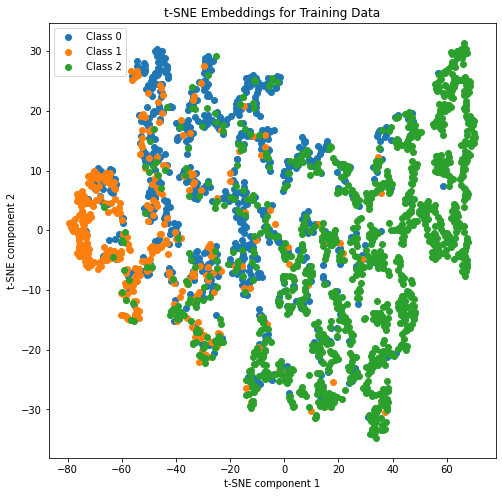

In [ ]:
from sklearn.manifold import TSNE

# Get embeddings for the training data
embeddings = []
labels = []
with torch.no_grad():
    for data in train_loader:
        images, targets = data[0].to(device), data[1].to(device)
        outputs = modelVGG3(images)
        embeddings.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(8,8))
for i in range(3):
    plt.scatter(embeddings_tsne[labels==i,0], embeddings_tsne[labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()